## Installation

In [ ]:
#%pip install 

# Download this repository
#!git clone https://github.com/pluskal-lab/DreaMS.git
#!cd DreaMS

# Create conda environment
#!conda update -n base -c defaults conda
#!conda create -n dreams python==3.11.0 --yes
#!conda init
#!conda activate dreams

# Install DreaMS
#%pip install -e ./DreaMS

#%pip install pytorch-lightning
#!git clone https://github.com/colorfulcereal/MassSpecGym
#%pip install wandb


In [ ]:
#pip3 install -e MassSpecGym

## How to enable GPU support for TensorFlow or PyTorch on MacOS
## https://medium.com/bluetuple-ai/how-to-enable-gpu-support-for-tensorflow-or-pytorch-on-macos-4aaaad057e74

## Loading the MassSpecGym dataset

In [1]:
from massspecgym.utils import load_massspecgym
df = load_massspecgym()
df.head(1)


,mzs,intensities,smiles,inchikey,formula,precursor_formula,parent_mass,precursor_mz,adduct,instrument_type,collision_energy,fold,simulation_challenge
identifier,,,,,,,,,,,,,
MassSpecGymID0000001,"[91.0542, 125.0233, 154.0499, 155.0577, 185.09...","[0.24524524524524524, 1.0, 0.08008008008008008...",CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC,VFMQMACUYWGDOJ,C16H17NO4,C16H18NO4,287.115224,288.1225,[M+H]+,Orbitrap,30.0,train,True


## MS/MS EDA

173830


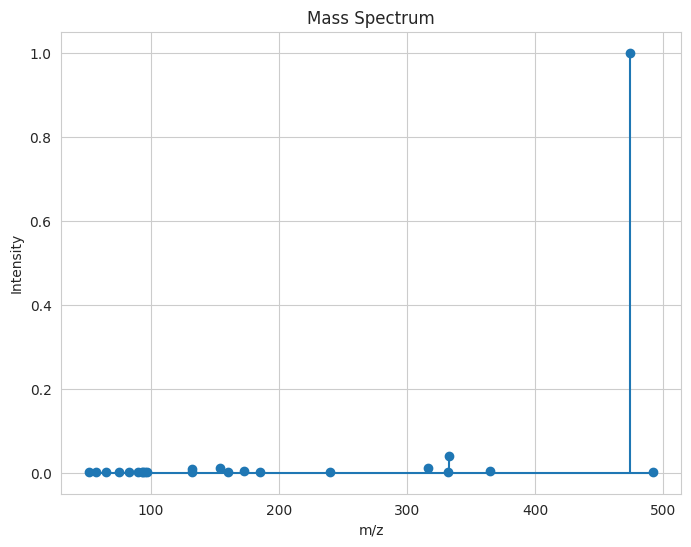

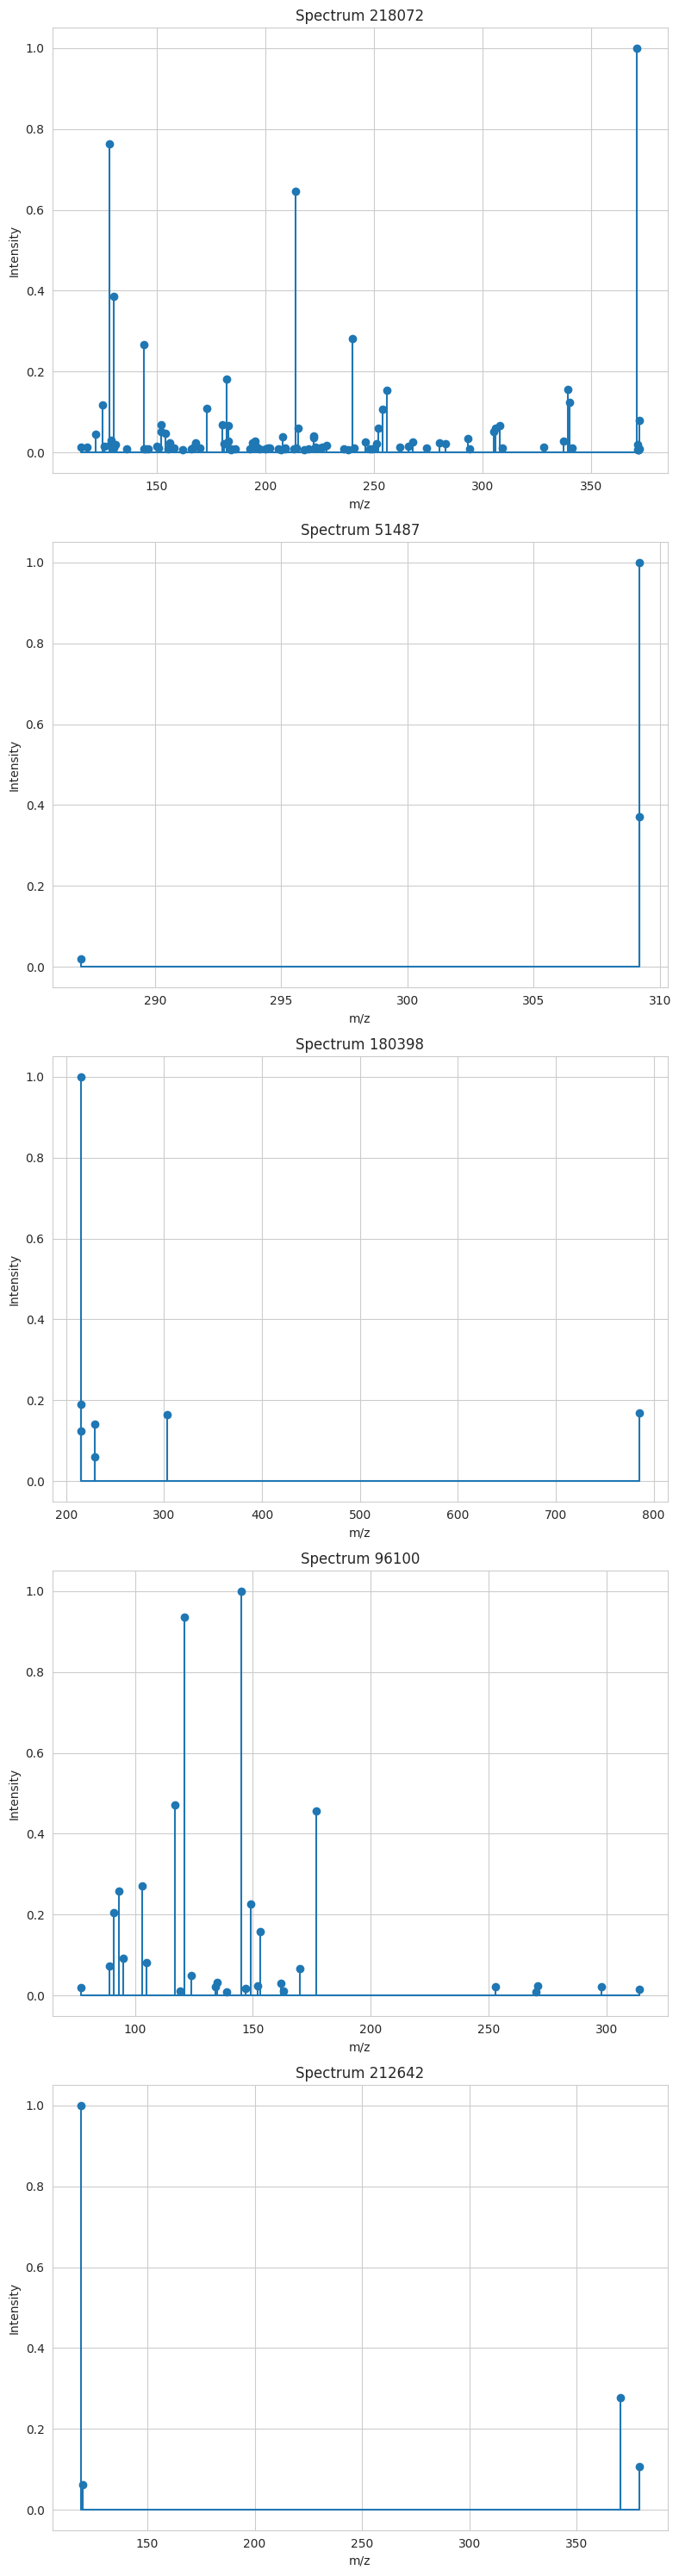

In [2]:
## Plot spectra

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set plot style
sns.set_style('whitegrid')

# Function to plot histogram of mzs and intensities
def plot_spectrum(mzs, intensities):
    plt.figure(figsize=(8, 6))
    plt.stem(mzs, intensities, basefmt='-')
    plt.title('Mass Spectrum')
    plt.xlabel('m/z')
    plt.ylabel('Intensity')
    plt.show()

# Plot a random spectrum
random_index = np.random.randint(0, len(df))
print(random_index)
mzs = df.iloc[random_index]['mzs']
intensities = df.iloc[random_index]['intensities']
plot_spectrum(mzs, intensities)

# Plot multiple spectra
num_spectra = 5
random_indices = np.random.randint(0, len(df), num_spectra)
fig, axs = plt.subplots(nrows=num_spectra, ncols=1, figsize=(8, 6*num_spectra))
for i, idx in enumerate(random_indices):
    mzs = df.iloc[idx]['mzs']
    intensities = df.iloc[idx]['intensities']
    axs[i].stem(mzs, intensities, basefmt='-')
    axs[i].set_title(f'Spectrum {idx}')
    axs[i].set_xlabel('m/z')
    axs[i].set_ylabel('Intensity')
plt.tight_layout()
plt.show()

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Halogen symbols
halogens = ['F', 'Cl', 'Br', 'I', 'At', 'Ts']

# Initialize halogen count dictionary
halogen_counts = {halogen: 0 for halogen in halogens}

# Count mass spectra containing each halogen
for index, row in df.iterrows():
    for halogen in halogens:
        if halogen in row['precursor_formula'] or halogen in row['formula']:
            if halogen == 'F':
                print(index)
            halogen_counts[halogen] += 1

# Calculate percentages
halogen_percentages = {halogen: (count/len(df))*100 for halogen, count in halogen_counts.items()}

# Print results
print("Halogen Percentages:")
for halogen, percentage in halogen_percentages.items():
    print(f"{halogen}: {percentage:.2f}%")

for halogen, count in halogen_counts.items():
    print(f"{halogen}: {count}")

# Plot (%)
# plt.bar(halogen_percentages.keys(), halogen_percentages.values())
# plt.xlabel('Halogen')
# plt.ylabel('Percentage (%)')
# plt.title('Distribution of Halogens in Mass Spectra')
# plt.ylim(0, 50)  # Set y-axis limit to 100%
# plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{x:.0f}%"))  # Format y-axis ticks as percentages
# plt.show()

# Plot results (count)
plt.bar(halogen_counts.keys(), halogen_counts.values())
plt.xlabel('Halogen')
plt.ylabel('Count')
plt.title('Distribution of Halogens in Mass Spectra By Count')
plt.show()

MassSpecGymID0002356
MassSpecGymID0002357
MassSpecGymID0002359
MassSpecGymID0002360
MassSpecGymID0002361
MassSpecGymID0002362
MassSpecGymID0002363
MassSpecGymID0002364
MassSpecGymID0002365
MassSpecGymID0013567
MassSpecGymID0013568
MassSpecGymID0013569
MassSpecGymID0013570
MassSpecGymID0013572
MassSpecGymID0013573
MassSpecGymID0013574
MassSpecGymID0013575
MassSpecGymID0013576
MassSpecGymID0013577
MassSpecGymID0013578
MassSpecGymID0013580
MassSpecGymID0013581
MassSpecGymID0013582
MassSpecGymID0013583
MassSpecGymID0013584
MassSpecGymID0013585
MassSpecGymID0013586
MassSpecGymID0013587
MassSpecGymID0013588
MassSpecGymID0013589
MassSpecGymID0013590
MassSpecGymID0013591
MassSpecGymID0013592
MassSpecGymID0013593
MassSpecGymID0013594
MassSpecGymID0013595
MassSpecGymID0013596
MassSpecGymID0013597
MassSpecGymID0013598
MassSpecGymID0013599
MassSpecGymID0013600
MassSpecGymID0013601
MassSpecGymID0013602
MassSpecGymID0013603
MassSpecGymID0013604
MassSpecGymID0013605
MassSpecGymID0013606
MassSpecGymID

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import numpy, sys

from massspecgym.data import RetrievalDataset, MassSpecDataModule
from massspecgym.data.transforms import SpecTokenizer, MolFingerprinter
from massspecgym.models.base import Stage
from massspecgym.models.retrieval.base import RetrievalMassSpecGymModel
numpy.set_printoptions(threshold=sys.maxsize)


In [ ]:
class MyDeepSetsRetrievalModel(RetrievalMassSpecGymModel):
    # constructor
    def __init__(
        self,
        hidden_channels: int = 128,
        out_channels: int = 4096,  # fingerprint size
        # out_channels: int = 4096,  # fingerprint size
        *args,
        **kwargs
    ):
        """Implement your architecture."""
        super().__init__(*args, **kwargs)

        self.phi = nn.Sequential(
            nn.Linear(2, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
        )
        self.rho = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, out_channels),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Implement your prediction logic."""
        x = self.phi(x)
        x = x.sum(dim=-2)  # sum over peaks
        x = self.rho(x)
        return x

    def step(
        self, batch: dict, stage: Stage
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """Implement your custom logic of using predictions for training and inference."""
        # Unpack inputs
        x = batch["spec"]  # input spectra
        fp_true = batch["mol"]  # true fingerprints
        cands = batch["candidates"]  # candidate fingerprints concatenated for a batch
        #print(cands)
        batch_ptr = batch["batch_ptr"]  # number of candidates per sample in a batch
        #print(batch_ptr)

        # Predict fingerprint
        fp_pred = self.forward(x)

        # Calculate loss
        loss = nn.functional.mse_loss(fp_true, fp_pred)

        # Calculate final similarity scores between predicted fingerprints and retrieval candidates
        fp_pred_repeated = fp_pred.repeat_interleave(batch_ptr, dim=0)
        scores = nn.functional.cosine_similarity(fp_pred_repeated, cands)

        return dict(loss=loss, scores=scores)

In [ ]:
# Init hyperparameters
n_peaks = 10
fp_size = 4096
batch_size = 2

# Load dataset
dataset = RetrievalDataset(
    spec_transform=SpecTokenizer(n_peaks=n_peaks),
    mol_transform=MolFingerprinter(fp_size=fp_size),
)

# Init data module
data_module = MassSpecDataModule(
    dataset=dataset,
    batch_size=batch_size,
    num_workers=4
)




In [ ]:
from lightning.pytorch import loggers as pl_loggers

# Init model
model = MyDeepSetsRetrievalModel(out_channels=fp_size)

# Init trainer
tb_logger = pl_loggers.TensorBoardLogger(save_dir="logs/")
trainer = Trainer(accelerator="auto", devices="auto", max_epochs=1, logger=tb_logger)

# Train
trainer.fit(model, datamodule=data_module)

## Fluoride Detection

In [7]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import numpy, sys
import wandb
from pathlib import Path
import torch.optim as optim

from massspecgym.data import MassSpecDataset, MassSpecDataModule
from massspecgym.data.transforms import SpecTokenizer, MolFingerprinter
from massspecgym.models.base import Stage
from massspecgym.models.retrieval.base import MassSpecGymModel
from sklearn.metrics import precision_score, recall_score
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.utilities import grad_norm

from torch import nn
import torch.nn.functional as F
from massspecgym.models.base import Stage
from dreams.api import PreTrainedModel
from dreams.models.dreams.dreams import DreaMS as DreaMSModel
from torchmetrics.classification import BinaryPrecision, BinaryRecall

import numpy as np

numpy.set_printoptions(threshold=sys.maxsize)


In [ ]:
import numpy as np
from rdkit import Chem
from massspecgym.data.transforms import MolToHalogensVector

# Example usage
checker = MolToHalogensVector()
smiles_string = "CC(F)(F)F"
halogen_vector = checker.from_smiles(smiles_string)
print(halogen_vector)
# Example usage
smiles_string = "CCBr"
halogen_vector = checker.from_smiles(smiles_string)
print(halogen_vector)

In [ ]:
pl.seed_everything(0)

DEBUG = False

if DEBUG:
    mgf_pth = Path("/teamspace/studios/this_studio/MassSpecGym/data/debug/example_5_spectra.mgf")
    split_pth = Path("/teamspace/studios/this_studio/MassSpecGym/data/debug/example_5_spectra_split.tsv")
else:
    mgf_pth = None
    split_pth = None

# Check if MPS is available, otherwise use CUDA
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
else:
    mps_device = None

In [4]:
# final model containing the network definition
class HalogenDetectorDreamsTest(MassSpecGymModel):
    def __init__(
        self,
        alpha: float=0.25,
        gamma: float=0.5,
        batch_size: int=64,
        threshold: float=0.5,
        *args,
        **kwargs
    ):
        super().__init__(*args, **kwargs)
        if mps_device is not None:
            self.alpha = torch.tensor([1-alpha, alpha], device=mps_device)
        else:
            self.alpha = torch.tensor([1-alpha, alpha]).cuda()
        self.gamma = gamma
        self.batch_size = batch_size
        self.threshold = threshold
        print(f"Training with threshold: {self.threshold}, alpha: {self.alpha}, gamma: {self.gamma}, batch_size: {self.batch_size}")
        
        # Metrics
        self.train_precision = BinaryPrecision()
        self.train_recall = BinaryRecall()
        self.val_precision = BinaryPrecision()
        self.val_recall = BinaryRecall()

        # loading the DreaMS model weights from the internet
        self.main_model = PreTrainedModel.from_ckpt(
            # ckpt_path should be replaced with the path to the ssl_model.ckpt model downloaded from https://zenodo.org/records/10997887
            ckpt_path="https://zenodo.org/records/10997887/files/ssl_model.ckpt?download=1", ckpt_cls=DreaMSModel, n_highest_peaks=60
        ).model.train()
        self.lin_out = nn.Linear(1024, 1) # for F

    def forward(self, x):
        output_main_model = self.main_model(x)[:, 0, :] # to get the precursor peak token embedding 
        fl_probability = F.sigmoid(self.lin_out(output_main_model))
        return fl_probability

    def step(
        self, batch: dict, stage: Stage
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """Implement your custom logic of using predictions for training and inference."""
        # Unpack inputs
        x = batch["spec"]  # shape: [batch_size, num_peaks + 1, 2]
        #print("--batch.keys", batch.keys())

        halogen_vector_true = batch["mol"] # shape: [batch_size, 4]
        # Extract the 1st column --> fluorine predictions
        true_values = halogen_vector_true[:, 0] # shape [batch_size]

        # the forward pass
        predicted_probs = self.forward(x) # shape [batch_size x 1]
        
        if DEBUG:
            predicted_probs = predicted_probs[0] # for testing
        else:
            predicted_probs = predicted_probs.squeeze() # shape [batch_size]

        #print("--predicted_probs", predicted_probs)

        ### Focal Loss: https://amaarora.github.io/posts/2020-06-29-FocalLoss.html ### 
        # Increase loss for minority misclassification (F = 1 but predicted as 0) and 
        # decreases loss for majority class misclassification (F = 0 but predicted as 1)
        # Our MassSpecGym training data is skewed with only 5% of molecules containing Fluorine
       
        bce_loss = nn.BCELoss(reduction='none')
        loss = bce_loss(predicted_probs, true_values)
        targets = true_values.type(torch.long)
        at = self.alpha.gather(0, targets.data.view(-1))
        pt = torch.exp(-loss)
        F_loss = at * (1 - pt)**self.gamma * loss
        return { 'loss': F_loss.mean() } 

    def on_batch_end(
        self, outputs: [], batch: dict, batch_idx: int, stage: Stage
    ) -> None:
        x = batch["spec"] # shape: [batch_size, num_peaks + 1, 2]
        halogen_vector_true = batch["mol"] # shape [batch_size]
        # updated predictions with the updated weights at the end of the batch
        pred_probs = self.forward(x) # shape [batch_size x 1]

        # thresholding
        halogen_vector_pred_binary = torch.where(pred_probs >= self.threshold, 1, 0)

        # Extract the 1st column --> fluorine predictions
        true_labels = halogen_vector_true[:, 0] # shape [batch_size]
        # make shape [batch_size x 1] into shape [batch_size]
        pred_bool_labels = halogen_vector_pred_binary.squeeze() # shape [batch_size]

        if stage.to_pref() == 'train_':
            self.train_precision.update(pred_bool_labels, true_labels)
            self.train_recall.update(pred_bool_labels, true_labels)
        elif stage.to_pref() == 'val_':
            self.val_precision.update(pred_bool_labels, true_labels)
            self.val_recall.update(pred_bool_labels, true_labels)

        self.log_dict({ f"{stage.to_pref()}/loss": outputs['loss'] },
                prog_bar=True,
                on_epoch=True,
                batch_size=self.batch_size
        )

    def _reset_metrics_train(self):
        # Reset states for next epoch
        self.train_precision.reset()
        self.train_recall.reset()

    def _reset_metrics_val(self):
        # Reset states for next epoch
        self.val_precision.reset()
        self.val_recall.reset()
        self.all_predicted_probs = []  # reset the list of predicted probabilities for validation

    def on_train_epoch_start(self) -> None:
        self._reset_metrics_train()

    def on_validation_epoch_start(self) -> None:
        self._reset_metrics_val()

    def on_train_epoch_end(self) -> None:
        precision = self.train_precision.compute()
        recall = self.train_recall.compute()
        f1_score = (2*precision*recall)/(precision + recall) if (precision + recall) != 0 else 0
        self.log_dict({
                f"train_/precision": precision,
                f"train_/recall": recall,
                f"train_/f1_score": f1_score
            },
            prog_bar=True,
            on_epoch=True,
            on_step=False
        )
        
    def on_validation_epoch_end(self) -> None:
        precision = self.val_precision.compute()
        recall = self.val_recall.compute()
        f1_score = (2*precision*recall)/(precision + recall) if (precision + recall) != 0 else 0
        self.log_dict({
                f"val_/precision": precision,
                f"val_/recall": recall,
                f"val_/f1_score": f1_score
            },
            prog_bar=True,
            on_epoch=True,
            on_step=False
        )

In [5]:
# removed adduct due to a str error
class TestMassSpecDataset(MassSpecDataset):

    def __getitem__(
        self, i: int, transform_spec: bool = True, transform_mol: bool = True
    ) -> dict:
        spec = self.spectra[i]
        metadata = self.metadata.iloc[i]
        mol = metadata["smiles"]

        # Apply all transformations to the spectrum
        item = {}
        if transform_spec and self.spec_transform:
            if isinstance(self.spec_transform, dict):
                for key, transform in self.spec_transform.items():
                    item[key] = transform(spec) if transform is not None else spec
            else:
                item["spec"] = self.spec_transform(spec)
        else:
            item["spec"] = spec

        # Apply all transformations to the molecule
        if transform_mol and self.mol_transform:
            if isinstance(self.mol_transform, dict):
                for key, transform in self.mol_transform.items():
                    item[key] = transform(mol) if transform is not None else mol
            else:
                item["mol"] = self.mol_transform(mol)
        else:
            item["mol"] = mol

        # Add other metadata to the item
        item.update({
            k: metadata[k] for k in ["precursor_mz"] # removed adduct due to a str error
        })

        if self.return_mol_freq:
            item["mol_freq"] = metadata["mol_freq"]

        if self.return_identifier:
            item["identifier"] = metadata["identifier"]

        # TODO: this should be refactored
        for k, v in item.items():
            if not isinstance(v, str):
                item[k] = torch.as_tensor(v, dtype=self.dtype)
        
        return item

In [ ]:
from pytorch_lightning.loggers import WandbLogger

# Init hyperparameters
max_epochs = 1
n_peaks = 60
threshold = 0.3 # 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1
alpha = 0.25 # 0.25, 0.5, 0.75, 1 - found 0.25 as best
gamma = 0.75 # 0.25, 0.5, 0.75, 1 - found 0.75 as best
lr = 1e-5


if DEBUG:
    batch_size = 1
else:
    batch_size = 64

# Load dataset
dataset = TestMassSpecDataset(
    spec_transform=SpecTokenizer(n_peaks=n_peaks),
    mol_transform = MolToHalogensVector(),
    pth='/teamspace/studios/this_studio/merged_massspec_nist20_with_fold.tsv'
)

# Init data module
data_module = MassSpecDataModule(
    dataset=dataset,
    batch_size=batch_size,
    split_pth=split_pth,
    num_workers=4
)

# Init model
model = HalogenDetectorDreamsTest(
    threshold=threshold,
    alpha=alpha,
    gamma=gamma,
    batch_size=batch_size,
    lr=lr
)
# initialise the wandb logger and name your wandb project
#wandb_logger = WandbLogger(project='HalogenDetection-FocalLoss-MergedMassSpecNIST20')
wandb_logger = WandbLogger(project='HalogenDetection-FocalLoss-Test')
# add your batch size to the wandb config
wandb_logger.experiment.config["batch_size"] = batch_size
wandb_logger.experiment.config["n_peaks"] = n_peaks
wandb_logger.experiment.config["threshold"] = threshold
wandb_logger.experiment.config["alpha"] = alpha
wandb_logger.experiment.config["gamma"] = gamma

trainer = Trainer(accelerator="auto", devices="auto", max_epochs=max_epochs, logger=wandb_logger, val_check_interval=0.1)

# Validate before training
data_module.prepare_data()  # Explicit call needed for validate before fit
data_module.setup()  # Explicit call needed for validate before fit
trainer.validate(model, datamodule=data_module)

# # Train
trainer.fit(model, datamodule=data_module)

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

## Detecting Fluorine

In [1]:
from pathlib import Path
from tqdm import tqdm
from dreams.utils.data import MSData
from dreams.api import dreams_predictions, PreTrainedModel
from dreams.models.heads.heads import BinClassificationHead
from dreams.utils.io import append_to_stem


def find_fluorine():

    # in_pth = 'data/teo/<in_file>.mgf'  # or .mzML
    # out_csv_pth = 'data/teo/<in_file>_f_preds.csv'

    # in_pths = list(Path('/scratch/project/open-26-5/DreaMS/data/andrej/fluorine_dataset').glob('*.mzML'))
    # model_ckpt_111k = '/scratch/project/open-26-5/DreaMS/dreams/HAS_F_1.0/Feb2025_8bs_5e-5lr_bce/epoch=30-step=111000.ckpt'
    # model_ckpt_7k = '/scratch/project/open-26-5/DreaMS/dreams/HAS_F_1.0/Feb2025_8bs_5e-5lr_bce/epoch=1-step=7000.ckpt'

    in_pth = Path('/teamspace/studios/this_studio/20250627_pa_flo_nmr_pos_norm.mzML')
    # threshold = 0.9 model
    model_ckpt = '/teamspace/studios/this_studio/HalogenDetection-FocalLoss-MergedMassSpecNIST20/opi4lx8s/checkpoints/epoch=0-step=8920.ckpt'

    n_highest_peaks = 60

    # Load model
    model = HalogenDetectorDreamsTest.load_from_checkpoint(model_ckpt)
    print(model)

    print(f'Processing {in_pth}...')

    # Load data
    try:
        msdata = MSData.load(in_pth, in_mem=True)
    except ValueError as e:
        print(f'Skipping {in_pth} because of {e}.')
        return

    # Compute fluorine probabilties
    df = msdata.to_pandas()
    
    f_preds = dreams_predictions(
        spectra=msdata,
        model_ckpt=model,
        n_highest_peaks=n_highest_peaks
    )
    df[f'F_preds'] = f_preds

        # Store predictions
    df.to_csv(append_to_stem(in_pth, 'F_preds').with_suffix('.csv'), index=False)


In [ ]:
find_fluorine()

## Scratch

In [ ]:
import torch
import torch.nn as nn

# Define the network
hidden_channels = 5
net = nn.Sequential(
    nn.Linear(2, hidden_channels),
    nn.ReLU(),
    nn.Linear(hidden_channels, hidden_channels),
    nn.ReLU(),
)

# Initialize the network
net = net.float()

# Create a dummy input tensor
input_tensor = torch.ones(5, 10, 2)
# Forward pass
output = net(input_tensor)
print(output) 

In [ ]:
true_values = np.array([1, 1., 1])
pred_values = np.array([0.0, 1, 1])

precision_score(true_values, pred_values)
recall_score(true_values, pred_values)

In [ ]:
from torch import nn
import torch.nn.functional as F
from massspecgym.models.base import Stage
from dreams.api import PreTrainedModel
from dreams.models.dreams.dreams import DreaMS as DreaMSModel

# Example forward pass (not needed to explicitly initialize the DataLoader if you are using MassSpecGym)
from massspecgym.data.datasets import MassSpecDataset
from massspecgym.data.transforms import SpecTokenizer
from torch.utils.data import DataLoader

dataset = MassSpecDataset(
    spec_transform=SpecTokenizer(n_peaks=n_peaks),
    mol_transform = MolToHalogensVector()
)
dataloader = DataLoader(dataset, batch_size=4)
model = HalogenDetectorDreams()

dummy_batch = next(iter(dataloader))
dummy_output = model(dummy_batch)
print(dummy_output)  # Should print a tensor of shape (4, 4) containing halogen probabilties


In [ ]:
m = nn.Sigmoid()
loss = nn.BCELoss(reduction='mean')
input = torch.tensor([[2.0, 3.0, 5.0], [2.0, 3.0, 5.0]])
print(m(input))
target = torch.tensor([[1.0, 0.0, 1.0], [1.0, 0.0, 0.0]])
print(target)
output = loss(m(input), target)
output

In [ ]:
import numpy as np
num_actual_positives    = np.array([1, 1, 1, 0, 0, 0, 0, 1, 1, 1])
num_predicted_positives = np.array([1, 1, 0, 0, 1, 0, 0, 1, 1, 0])

print(np.sum(np.logical_and(num_actual_positives, num_predicted_positives)))

# a1 = np.array([1, 1, 0])
# a2 = np.array([0, 0, 1])

# print(np.sum(np.logical_and(a1, a2))) # should return 0

In [ ]:
#check for gpu
if torch.backends.mps.is_available():
   mps_device = torch.device("mps")
   x = torch.ones(1, device=mps_device)
   print (x)
else:
   print ("MPS device not found.")

In [ ]:
import time
# GPU
start_time = time.time()

# syncrocnize time with cpu, otherwise only time for oflaoding data to gpu would be measured
torch.mps.synchronize()

a = torch.ones(4000,4000, device="mps")
for _ in range(200):
   a +=a

elapsed_time = time.time() - start_time
print( "GPU Time: ", elapsed_time)

In [4]:
# pip install rdkit-pypi
from rdkit import Chem
from collections import defaultdict

def _is_pf_carbon(a: Chem.Atom) -> bool:
    """Aliphatic carbon with 0 H and 2 or 3 attached fluorines (CF2/CF3)."""
    if a.GetAtomicNum() != 6 or a.GetIsAromatic():
        return False
    if a.GetTotalNumHs() != 0:
        return False
    f = sum(1 for n in a.GetNeighbors() if n.GetAtomicNum() == 9)
    return f in (2, 3)

def _pf_carbon_graph_edges(mol: Chem.Mol):
    """
    Build edges between PF-carbons:
      - direct C–C bond between PF-carbons
      - ether bridge PF-C–O–PF-C becomes an edge between those PF-carbons
    Returns: set of carbon indices, adjacency dict (carbons only)
    """
    cset = {a.GetIdx() for a in mol.GetAtoms() if _is_pf_carbon(a)}
    adj = defaultdict(set)

    # Direct PF-carbon to PF-carbon bonds
    for b in mol.GetBonds():
        i, j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        if i in cset and j in cset:
            adj[i].add(j)
            adj[j].add(i)

    # Ether bridges: PF-C -- O -- PF-C  => connect the PF-carbons
    for a in mol.GetAtoms():
        if a.GetAtomicNum() != 8 or a.GetIsAromatic():
            continue
        nbrs = [n.GetIdx() for n in a.GetNeighbors() if n.GetAtomicNum() == 6]
        if len(nbrs) == 2 and nbrs[0] in cset and nbrs[1] in cset:
            i, j = nbrs
            adj[i].add(j)
            adj[j].add(i)

    return cset, adj

def has_pf_chain_ge_2(smiles: str) -> bool:
    """
    Fast test: returns True iff there is at least one PF-carbon connected to another PF-carbon
    (directly or via ether). This excludes isolated CF3/CF2 cases.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return False
    cset, adj = _pf_carbon_graph_edges(mol)
    return any(len(adj[c]) > 0 for c in cset)


# --- quick demo ---
tests = [
    "FC(F)(F)c1ccccc1",                          # isolated CF3 on aromatic -> False
    "O=C(O)C(F)F",                               # isolated CF2 -> False
    "O=C(O)C(F)(F)C(F)(F)F",                     # short chain -> True for ge2, True/False for ge3 depending
    "O=C(O)C(C(O)(F)F)(F)OC(C(F)(F)F)(F)F",      # ether PFAS -> True
    "C(=O)(C(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)O",  #PFOA
]
for smi in tests:
    print(smi, "ge2:", has_pf_chain_ge_2(smi))


FC(F)(F)c1ccccc1 ge2: False
O=C(O)C(F)F ge2: False
O=C(O)C(F)(F)C(F)(F)F ge2: True
O=C(O)C(C(O)(F)F)(F)OC(C(F)(F)F)(F)F ge2: True
C(=O)(C(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)O ge2: True
